In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Reshape,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    BatchNormalization,
    Activation,
)

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Numpy: 1.19.5
Pandas: 1.2.4
Matplotlib: 3.4.1
Plotnine: 0.8.0


In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

In [5]:
A = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=64, num_spectrogram_bins=512+1, sample_rate=16_000, dtype=tf.float32
)

In [6]:
def mel(item):
    audio = tf.cast(item["audio"], tf.float32)
    audio = audio / 2**15

    stfts = tf.signal.stft(
            audio,
            frame_length=1024,
            frame_step=512,
            pad_end=False,  # librosa test compatibility
        )
    mag_stfts = tf.abs(stfts)

    melgrams = tf.tensordot(
            tf.square(mag_stfts), A, axes=1
    )

    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
        
    log_melgrams = _tf_log10(melgrams + 10e-6)

    concat_melgrams = tf.concat(
        [
            log_melgrams,
            tf.roll(log_melgrams, shift=-1, axis=0),
            tf.roll(log_melgrams, shift=-2, axis=0),
            tf.roll(log_melgrams, shift=-3, axis=0),
            tf.roll(log_melgrams, shift=-4, axis=0)
        ],
        axis=1,
    )
    concat_melgrams = concat_melgrams[:-4,:]

    item["audio"] = concat_melgrams
    return item

In [7]:
def prep_train(item):
    return item["audio"], item["audio"]

In [8]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(mel)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(mel)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(mel)
test2 = test.batch(BATCH_SIZE)

In [9]:
input = Input(shape=(307, 320))
h = Dense(128)(input)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(64)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(8)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(64)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(128)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
output = Dense(320, activation=None)(h)

autoencoder = Model(inputs=input, outputs=output)

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 307, 320)]        0         
_________________________________________________________________
dense (Dense)                (None, 307, 128)          41088     
_________________________________________________________________
batch_normalization (BatchNo (None, 307, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 307, 128)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 307, 64)           8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 307, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 307, 64)           0     

In [11]:
def my_loss(y_true, y_pred):
    error = tf.math.reduce_mean(tf.math.square(y_true-y_pred),axis=-1)
    return error

In [12]:
autoencoder.compile(optimizer='adam', loss=my_loss)

In [13]:
log_dir = os.path.join('..', 'logs', 'semi-mel', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [14]:
checkpoint_filepath = os.path.join("tmp", "semi-mel", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [15]:
history = autoencoder.fit(
    train2,
    epochs=100,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/100
6/6 [==============================] - 43s 7s/step - loss: 1.4108 - val_loss: 1.1191
Epoch 2/100
6/6 [==============================] - 43s 8s/step - loss: 0.9013 - val_loss: 0.9338
Epoch 3/100
6/6 [==============================] - 42s 7s/step - loss: 0.5618 - val_loss: 0.7319
Epoch 4/100
6/6 [==============================] - 42s 8s/step - loss: 0.3665 - val_loss: 0.6468
Epoch 5/100
6/6 [==============================] - 42s 8s/step - loss: 0.2677 - val_loss: 0.5301
Epoch 6/100
6/6 [==============================] - 42s 8s/step - loss: 0.2195 - val_loss: 0.4630
Epoch 7/100
6/6 [==============================] - 43s 8s/step - loss: 0.1928 - val_loss: 0.4098
Epoch 8/100
6/6 [==============================] - 43s 8s/step - loss: 0.1782 - val_loss: 0.3772
Epoch 9/100
6/6 [==============================] - 42s 8s/step - loss: 0.1659 - val_loss: 0.3464
Epoch 10/100
6/6 [==============================] - 42s 8s/step - loss: 0.1582 - val_loss: 0.3266
Epoch 11/100
6/6 [===========

In [16]:
audios = train.concatenate(test)

In [17]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

In [18]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.mean(np.square(item["audio"] - pred), axis=-1))
    error_lst.append(error)

In [19]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df.sample(5)

,audio,id,machine_id,split,label
159,"[[0.30060008, 0.01687514, 0.24850959, 0.306478...",0679,02,0,0
2024,"[[0.17815126, 0.11952008, -0.18551789, -0.6380...",0382,06,0,0
467,"[[0.45768705, 0.14419562, 0.41779798, -0.04913...",0348,06,0,0
997,"[[0.45829755, -0.03203686, -0.10010098, 0.3346...",0563,06,0,0
984,"[[-0.059200175, -0.1718162, 0.33661178, -0.089...",0476,00,0,0


In [20]:
audios_df["error"] = error_lst

In [21]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
2561,"[[-0.17709485, -0.77872664, -0.8691367, -0.588...",0046,06,0,0,0.283806
227,"[[0.28414956, -0.024269417, -0.095529765, 0.13...",0315,00,0,0,0.122618
1907,"[[-0.78875446, -0.7165994, -1.5522012, -0.5381...",0760,00,0,0,0.288443
2958,"[[-1.3695989, -0.74121344, -0.6997086, -0.8237...",0226,02,0,0,0.324572
1455,"[[0.33078793, -0.1051887, -0.5924341, -0.07968...",0779,00,0,0,0.395189


In [22]:
(
    audios_df
    .query("split == 0")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error          
                mean       std
machine_id                    
00          0.308289  0.160452
02          0.305201  0.167505
04          0.315170  0.177604
06          0.304169  0.139089

In [23]:
(
    audios_df
    .query("split == 1")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error          
                      mean       std
label machine_id                    
0     00          0.375100  0.215612
      02          0.347144  0.169299
      04          0.354780  0.154236
      06          0.385813  0.227005
1     00          0.399764  0.232305
      02          0.384116  0.242445
      04          0.352222  0.188781
      06          0.347726  0.164327

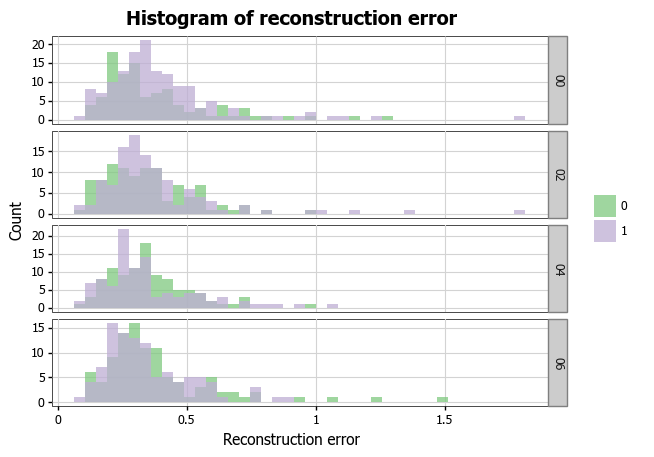

In [24]:
p = (
    p9.ggplot(audios_df.query("split == 1"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Reconstruction error")
    + p9.scale_y_continuous(name="Count")
    + p9.labs(
        title="Histogram of reconstruction error",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)